In [326]:
import csv

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
import numpy  as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [327]:
# Read in the csv data using pandas
df  = pd.read_csv('../../data/tables/X_trainGBM.csv', index_col=0)
label = pd.read_csv('../../data/tables/Y_trainGBM.csv')
print(label.head())

                                Sample  ID
0  TMA 27 R1 | 001 | Geometric Segment   0
1  TMA 27 R1 | 002 | Geometric Segment   0
2  TMA 27 R1 | 003 | Geometric Segment   0
3  TMA 27 R1 | 004 | Geometric Segment   0
4  TMA 27 R1 | 005 | Geometric Segment   0


In [328]:
import os, shutil
folder = '../../data/table_out/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [329]:
#remove last row of weird formatting from file to prevent NaNs
last_row = df.index[-1]
df_nonull = df.drop(last_row)
print(df_nonull.head())

            TMA 27 R1 | 001 | Geometric Segment  \
TargetName                                        
ATP7B                                 49.983944   
ERN1                                  60.775932   
KRT74                                 31.239965   
SPECC1L                               46.007948   
FOXJ1                                 45.439949   

            TMA 27 R1 | 002 | Geometric Segment  \
TargetName                                        
ATP7B                                 46.519148   
ERN1                                  49.501144   
KRT74                                 34.591161   
SPECC1L                               47.115547   
FOXJ1                                 54.272339   

            TMA 27 R1 | 003 | Geometric Segment  \
TargetName                                        
ATP7B                                 51.213741   
ERN1                                  42.021531   
KRT74                                 26.920043   
SPECC1L                      

In [330]:
#transpose to make concatting easier with the ID's
df_transposed = df_nonull.transpose()
df_transposed.to_csv('../../data/tables/X_trainGBM_transposed.csv')
print(df_transposed.head())

TargetName                               ATP7B       ERN1      KRT74  \
TMA 27 R1 | 001 | Geometric Segment  49.983944  60.775932  31.239965   
TMA 27 R1 | 002 | Geometric Segment  46.519148  49.501144  34.591161   
TMA 27 R1 | 003 | Geometric Segment  51.213741  42.021531  26.920043   
TMA 27 R1 | 004 | Geometric Segment  45.655397  50.591115  44.421467   
TMA 27 R1 | 005 | Geometric Segment  60.557470  49.547021  39.637617   

TargetName                             SPECC1L      FOXJ1     OR4K15  \
TMA 27 R1 | 001 | Geometric Segment  46.007948  45.439949  58.503934   
TMA 27 R1 | 002 | Geometric Segment  47.115547  54.272339  58.447134   
TMA 27 R1 | 003 | Geometric Segment  43.991290  55.153259  51.870327   
TMA 27 R1 | 004 | Geometric Segment  33.316100  59.228623  53.058975   
TMA 27 R1 | 005 | Geometric Segment  45.142842  67.163740  56.153291   

TargetName                                 PDC      MUC15   C1orf189  \
TMA 27 R1 | 001 | Geometric Segment  40.327955  24.991972  58.

In [331]:
#split the transposed DS into 90/10 split for training/testing
mask = np.random.rand(len(df_transposed)) <= 0.9
train = df_transposed[mask]
label_train = label[mask]
test = df_transposed[~mask]

In [332]:
#check how many in each cohort
test.to_csv('../../data/table_out/test.csv')
train.to_csv('../../data/table_out/train.csv')
print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")
test_number = test.shape[0]

No. of training examples: 242
No. of testing examples: 30


In [333]:
#check to make sure no NaNs
train_transposed = pd.read_csv('../../data/table_out/train.csv')
train_transposed.isnull().values.any()

False

In [334]:
ID_list = label_train['ID'].tolist()
print(ID_list)
print("length of ID list is: {}".format(len(ID_list)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
length of ID list is: 242


In [335]:
train_transposed["ID"] = ID_list
print(train_transposed.head())

                            Unnamed: 0      ATP7B       ERN1      KRT74  \
0  TMA 27 R1 | 001 | Geometric Segment  49.983944  60.775932  31.239965   
1  TMA 27 R1 | 002 | Geometric Segment  46.519148  49.501144  34.591161   
2  TMA 27 R1 | 003 | Geometric Segment  51.213741  42.021531  26.920043   
3  TMA 27 R1 | 004 | Geometric Segment  45.655397  50.591115  44.421467   
4  TMA 27 R1 | 006 | Geometric Segment  49.202945  53.675940  32.801963   

     SPECC1L      FOXJ1     OR4K15        PDC      MUC15   C1orf189  ...  \
0  46.007948  45.439949  58.503934  40.327955  24.991972  58.503934  ...   
1  47.115547  54.272339  58.447134  40.555154  22.066775  48.904745  ...   
2  43.991290  55.153259  51.870327  38.082012  25.606870  45.304463  ...   
3  33.316100  59.228623  53.058975  50.591115  28.380382  49.357186  ...   
4  38.765956  38.765956  38.765956  34.292961  31.310965  53.675940  ...   

        MAT2A     C2CD4C       M1AP       IQCD      OR2H1    C1QTNF3  \
0  163.015816  29.53

In [336]:
test_transposed = pd.read_csv('../../data/table_out/test.csv')
test_transposed.isnull().values.any()

False

In [337]:
#drop second column to remove the string Id's (ex. TMA 27 R1 | 001 | Geometric Segment)

col = [0]
train_transposed.drop(train_transposed.columns[col], axis=1, inplace=True)
test_transposed.drop(test_transposed.columns[col], axis=1, inplace=True)

train_transposed.to_csv('../../data/table_out/train_transposed_nostr.csv')
test_transposed.to_csv('../../data/table_out/test_transposed_nostr.csv')

print(train_transposed.head())
print(test_transposed.head())


       ATP7B       ERN1      KRT74    SPECC1L      FOXJ1     OR4K15  \
0  49.983944  60.775932  31.239965  46.007948  45.439949  58.503934   
1  46.519148  49.501144  34.591161  47.115547  54.272339  58.447134   
2  51.213741  42.021531  26.920043  43.991290  55.153259  51.870327   
3  45.655397  50.591115  44.421467  33.316100  59.228623  53.058975   
4  49.202945  53.675940  32.801963  38.765956  38.765956  38.765956   

         PDC      MUC15   C1orf189        ZXDC  ...       MAT2A     C2CD4C  \
0  40.327955  24.991972  58.503934   98.263889  ...  163.015816  29.535967   
1  40.555154  22.066775  48.904745   99.002289  ...  171.763007  33.994762   
2  38.082012  25.606870  45.304463  102.427481  ...  212.733999  27.576630   
3  50.591115  28.380382  49.357186   80.205427  ...  146.837628  22.210734   
4  34.292961  31.310965  53.675940   76.040914  ...  162.518817  35.783960   

        M1AP       IQCD      OR2H1    C1QTNF3      RAB42      PTPRJ  \
0  34.647961  36.919958  31.80796

In [338]:
train_transposed_nostr = pd.read_csv('../../data/table_out/train_transposed_nostr.csv')
test_transposed_nostr = pd.read_csv('../../data/table_out/test_transposed_nostr.csv')
X = train_transposed_nostr.iloc[:,:-1]
y = train_transposed_nostr['ID']

In [339]:
y.value_counts().to_frame().T

,1,0
ID,151,91


In [340]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [341]:
y_resampled.value_counts().to_frame().T

,0,1
ID,151,151


In [342]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled,
                                                  train_size=0.5,
                                                  test_size=0.2,
                                                  random_state=123,
                                                  shuffle=True)

In [343]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
test    = scaler.transform(test_transposed_nostr)

In [344]:
model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X_train.shape[-1],) ),
        # randomly delete 30% of the input units below
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        # the output layer, with a single neuron
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# save the initial weights for later
initial_weights = model.get_weights()

In [345]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 9)                 168048    
                                                                 
 dropout_6 (Dropout)         (None, 9)                 0         
                                                                 
 dense_19 (Dense)            (None, 9)                 90        
                                                                 
 dense_20 (Dense)            (None, 1)                 10        
                                                                 
Total params: 168,148
Trainable params: 168,148
Non-trainable params: 0
_________________________________________________________________


In [346]:
learning_rate = 0.001

model.compile(optimizer=keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=keras.metrics.AUC()
             )

In [347]:
history = model.fit(X_train, y_train,
          epochs=500,
          batch_size=1000,
          validation_data=(X_val, y_val),
          verbose=3,
          # add in our early stopping callback
          # callbacks=[early_stopping]
        )

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [348]:
history.history
print(history.history.keys())

dict_keys(['loss', 'auc_7', 'val_loss', 'val_auc_7'])


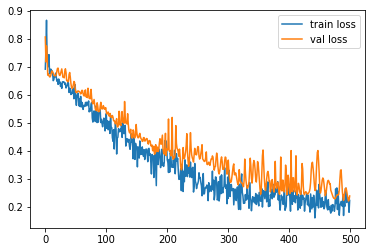

In [349]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
# plt.savefig('vgg-loss-rps-1.png')
plt.show()

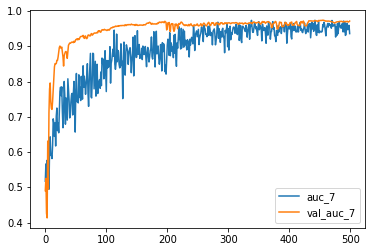

In [352]:
num = 7
plt.plot(history.history['auc_'+ str(num)], label='auc_' + str(num))
plt.plot(history.history['val_auc_' + str(num)], label='val_auc_' + str(num))
plt.legend()
plt.show()


In [353]:
import csv
header = ["name", "ID"]
name_list = label_train['Sample'].tolist()
print(name_list)
f = open('../../data/table_out/sample.csv', 'w')
writer = csv.writer(f)
# write the header
writer.writerow(header)
f.close()

['TMA 27 R1 | 001 | Geometric Segment', 'TMA 27 R1 | 002 | Geometric Segment', 'TMA 27 R1 | 003 | Geometric Segment', 'TMA 27 R1 | 004 | Geometric Segment', 'TMA 27 R1 | 006 | Geometric Segment', 'TMA 27 R1 | 007 | Geometric Segment', 'TMA 27 R1 | 008 | Geometric Segment', 'TMA 27 R1 | 009 | Geometric Segment', 'TMA 27 R1 | 011 | Geometric Segment', 'TMA 27 R1 | 012 | Geometric Segment', 'TMA 27 R1 | 013 | Geometric Segment', 'TMA 27 R1 | 014 | Geometric Segment', 'TMA 27 R1 | 015 | Geometric Segment', 'TMA 27 R1 | 016 | Geometric Segment', 'TMA 27 R1 | 017 | Geometric Segment', 'TMA 27 R1 | 018 | Geometric Segment', 'TMA 27 R1 | 020 | Geometric Segment', 'TMA 27 R1 | 021 | Geometric Segment', 'TMA 27 R1 | 022 | Geometric Segment', 'TMA 27 R1 | 024 | Geometric Segment', 'TMA 27 R1 | 025 | Geometric Segment', 'TMA 27 R1 | 026 | Geometric Segment', 'TMA 27 R1 | 027 | Geometric Segment', 'TMA 27 R1 | 028 | Geometric Segment', 'TMA 27 R1 | 029 | Geometric Segment', 'TMA 27 R1 | 030 | Geome

In [354]:
sample = pd.read_csv('../../data/table_out/sample.csv')
sample['ID'] = model.predict(test_transposed_nostr).tolist()
model.evaluate(test_transposed_nostr)
sample['name'] = name_list[:test_number]
sample.to_csv('../../data/table_out/submission.csv', index=False)



1/1 [==============================] - 0s 67ms/step - loss: 0.0000e+00 - auc_7: 0.0000e+00
